In [1]:
# Libraries and functions
import sys
sys.path.append("../functions/")
from calibration import get_weekly_new_deaths
from plot import plot_deaths_aggregated

import numpy as np
import pandas as pd
from datetime import datetime, timedelta


model_list = ['0', 'I', 'B', 'IB', 'C', 'CI', 'CB', 'CIB']                                 # list of strings with model codes
path_simulations = '../runs/sampled/'                                                      # path where to find simulations

In [2]:
# Parameters

t_step = 1                                                          # temporal step (in days)
initial_date = datetime(2020, 9, 14)                                # starting date of the simulation
end_date = datetime(2021, 2, 21)                                    # ending date of the simulation
t_max = int((end_date - initial_date).days * (1/t_step))            # number of days in the simulation

# Import and preprocessing observed data

# Load the weekly mortality data
df_deaths = pd.read_csv('../data/deaths/weekly_deaths.csv')

# Compute period (initial and final week) on which we perfored the calibration 
# initial_week: 2 weeks after initial_date to give the model time to adjust
initial_week = (initial_date + timedelta(days=14)).strftime("%Y-%W")
initial_week = f"{int(initial_week[:4]) - 1}-52" if initial_week.endswith('-00') else initial_week    # adjust for week 00 if necessary

# final_week: week of end_date
final_week = end_date.strftime("%Y-%W")
final_week = f"{int(final_week[:4]) - 1}-52" if final_week.endswith('-00') else final_week            # adjust for week 00 if necessary

# Define observed weekly deaths for plotting
df_deaths = df_deaths.groupby('week')['weekly_deaths'].sum().reset_index()
deaths_observed = df_deaths.loc[(df_deaths['week'] >= initial_week) & (df_deaths['week'] <= final_week)]
deaths_observed = deaths_observed['weekly_deaths'].values

In [3]:
# --- Prepare Simulations Data for Plotting ---

# Dictionaries to store the list of simulations for each model. Keys will be model strings (e.g., 'CIB'), values will be lists of arrays (n_sim x n_weeks)
simulations_total_dict = {}
# List to store the specific week labels (e.g., '2020-45') for the x-axis. It is enough to do it just once since the time window is the same for all models.
dates_list = []                                                     

# Loop through each model configuration to process its simulations
for model_string in model_list:

    # Define the file path for the sampled simulations (using compressed pickle format)
    file_name = f"sampled_simulations_model_{model_string}.pkl.gz"

    # Load the DataFrame containing parameters and the y simulation arrays
    df_model = pd.read_pickle(path_simulations + file_name)

    # Temporary list to hold the processed death counts for the current model
    simulations_total = []

    # Iterate through each simulation (row) in the DataFrame
    for i, row_df in df_model.iterrows():

        # Extract the raw simulation output array y of shape: (n_age, n_gen, n_comp, t_max)
        y = row_df["y"]   

        # Process the raw output to get weekly new deaths, aggregation='total' returns two values: the list of weeks and the aggregated deaths     
        weeks_list, daily_deaths_list_total = get_weekly_new_deaths(y, initial_date, t_max, t_step, aggregation='total', n_comp_deaths=5)

        # Append the weekly death series to the model's list
        simulations_total.append(daily_deaths_list_total)

        # Store the week labels from the first simulation of the first model
        if not dates_list:
            dates_list = weeks_list

    # Assign the full list of processed simulations to the main dictionary
    simulations_total_dict[model_string] = simulations_total

Figure saved to ../outputs/Deaths_aggregated_rmse.png


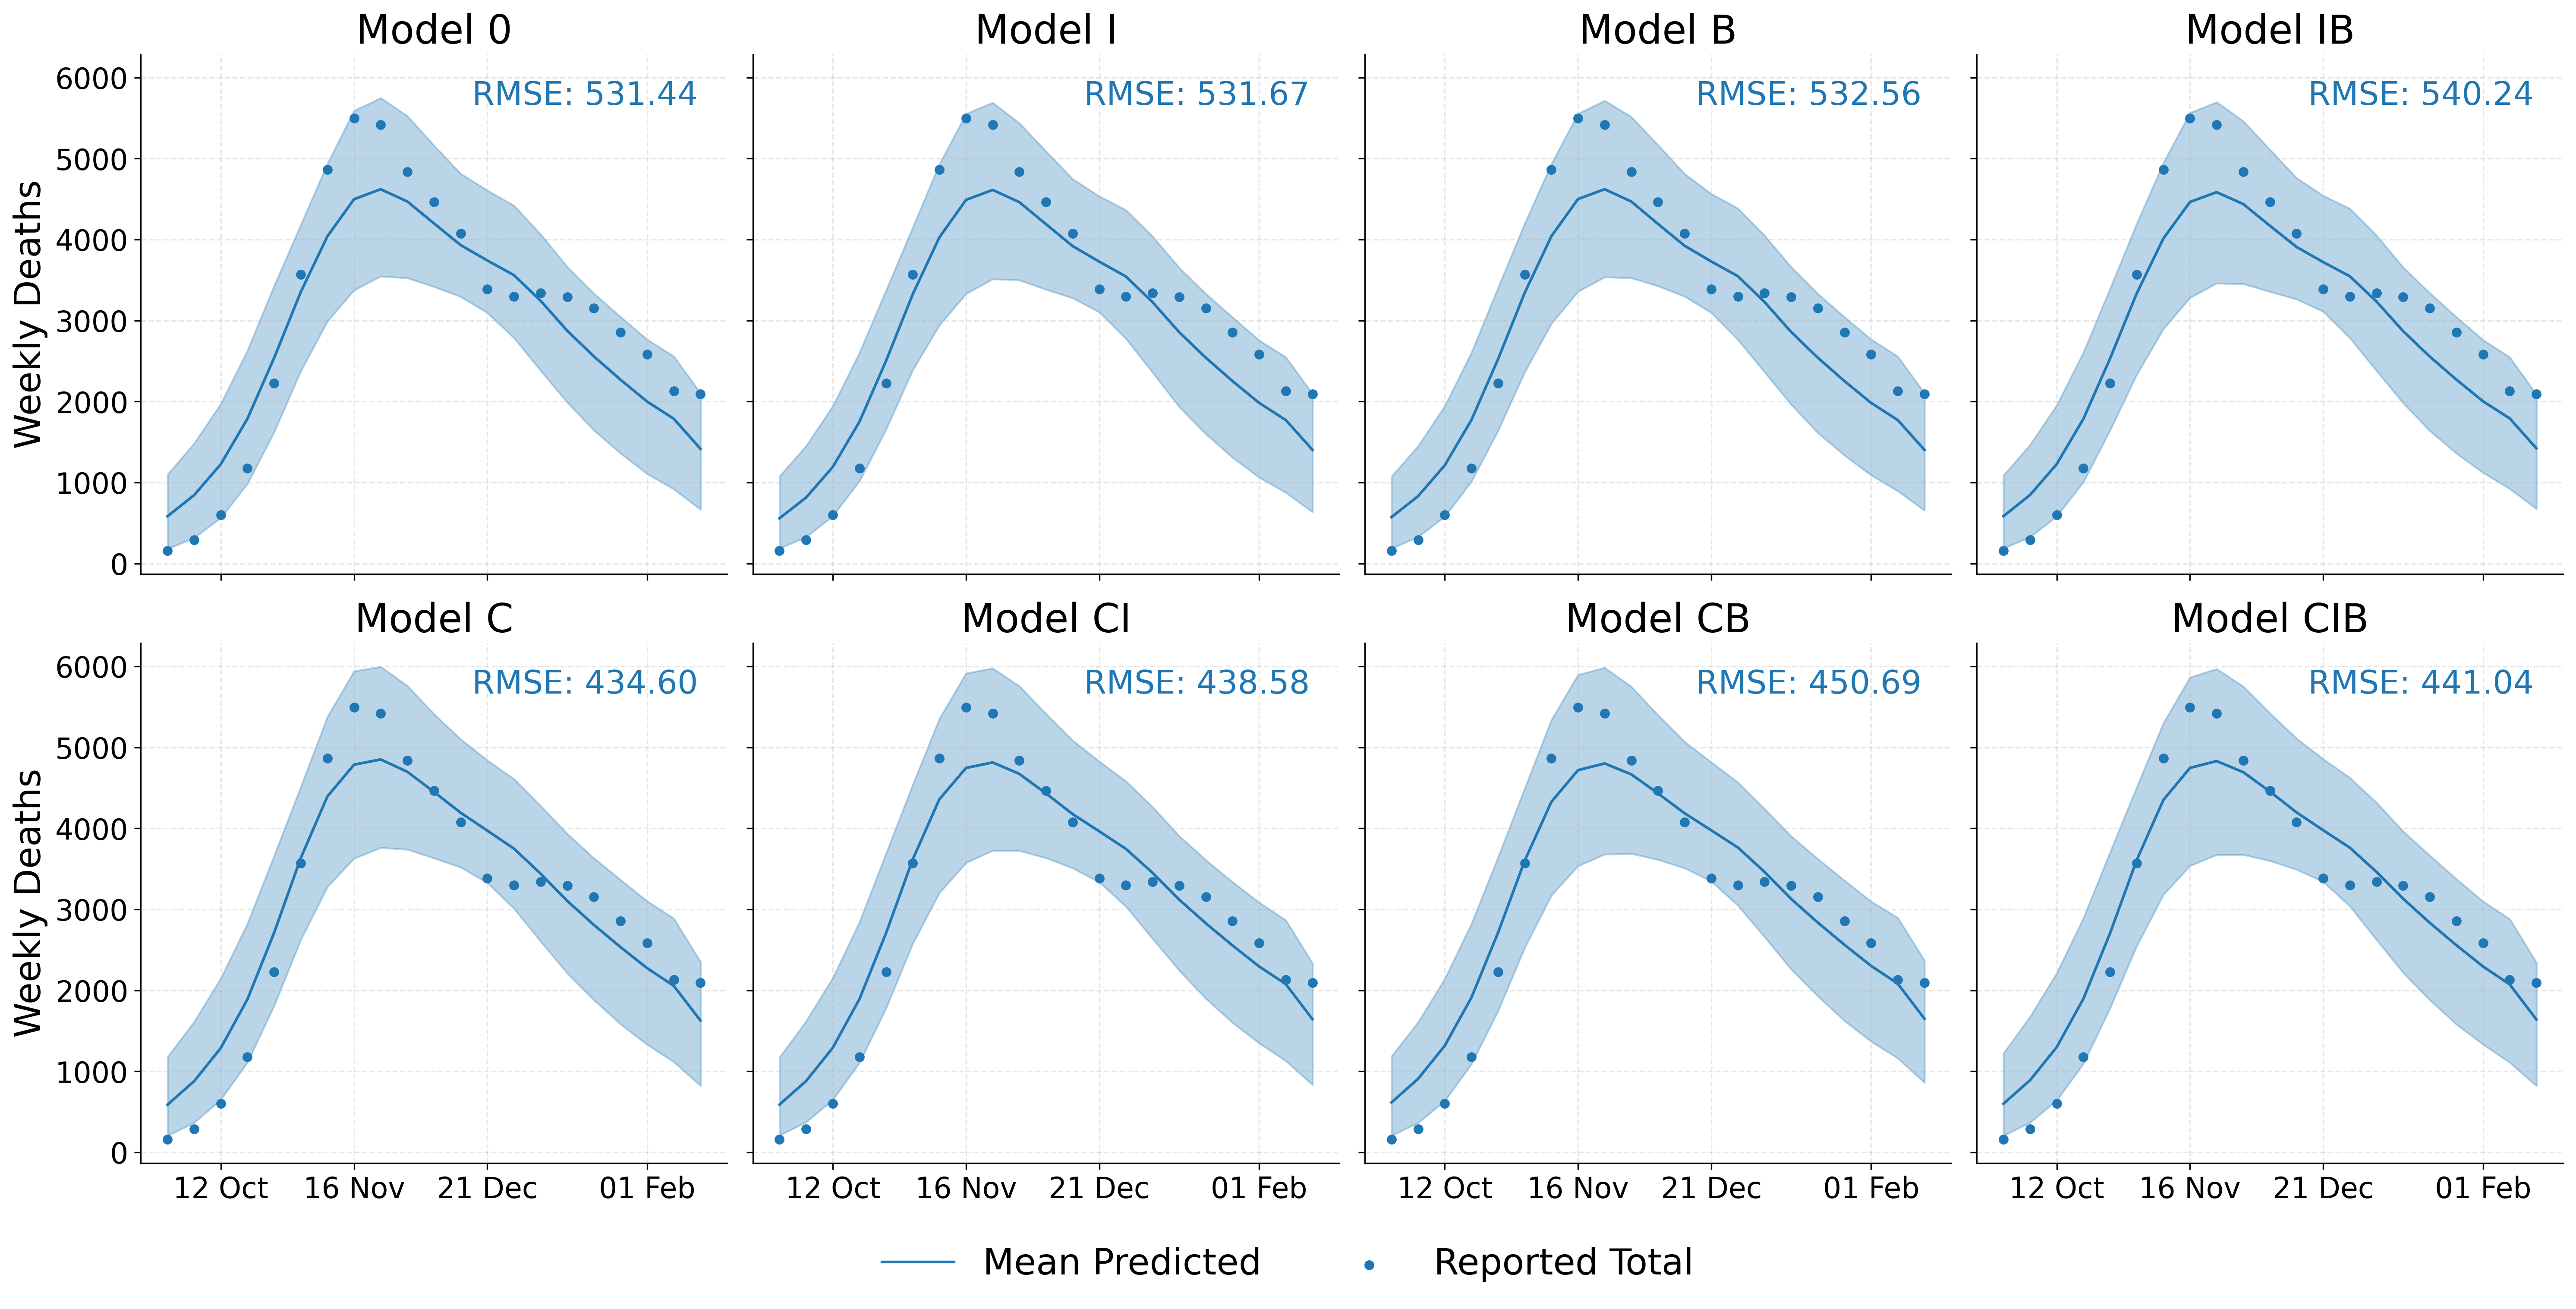

In [4]:
# --- Call the Plotting Function ---
plot_deaths_aggregated(simulations_total_dict, deaths_observed, dates_list, output_path='../outputs/Deaths_aggregated_rmse.png')